# Overview

We comperehend the task as trying to find out how non-normality of data and its collinearity affects the false positive rate (Type I error) and the false negative rate (Type II error). For that reason, the proposed computational simulation has been run. Below, all the code used for the simulation and the analysis with output. 

The results are provided here for easier access with references as required.


# Simulation

## Generating Data (Data Generation Process)

**The task**: 

>Generate four “populations” of data: normal, lightly skewed, medium-skewed, heavily-skewed. This is your dependent variable (DV). Using dependent variables (DV), generate independent variables (IV) that correlate with each DV at 0%, 10%, 30%, 50%, and 70% (so you’ll end up with 20 “populations” of IVs).

The notation:

* The dependent variables are $y_i,\space i = 1..4$,
* The independent variables (a different set for each $y_i$) are $X = [x_{j}],\space j = 1..5$,
* There are four cases $y_i = a X + \epsilon$: normal, lightly skewed, medium-skewed, heavily-skewed.

I use the [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) (with the skewness parameter $\alpha$) to generate samples for each case, each sample of the size n = 10000. The skewness parameter is set as follows

* $\alpha = 0$ for the normal distribution,
* $\alpha = 2$ for the lighty skewed normal distribution,
* $\alpha = 5$ for medium-skewed normal distribution,
* $\alpha = 25$ for heavily-skewed normal distribution.

For each DV I generate the other five IV's at the required levels of correlation by using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Loading required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#from scipy.stats import skewnorm
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm

plt.style.use('seaborn')

Setting some global and initial parameters

In [3]:
# the sample size (per case)
total_sample_size = 10000

# number of cases
cases_no = 4

# parameters of distributions
#   skewed_0 - normal, 
#   skewed_{i} - skewed (the more skewed the greater the index is)
norm_dist_params = {'xi': scipy.stats.skewnorm(loc = 0, scale = 1, a = 0),
                    'y0': scipy.stats.skewnorm(loc = 0, scale = 1, a = 0),
                    'y1': scipy.stats.skewnorm(loc = 0, scale = 1, a = 2),
                    'y2': scipy.stats.skewnorm(loc = 0, scale = 1, a = 5),
                    'y3': scipy.stats.skewnorm(loc = 0, scale = 1, a = 25)}

# the correlation matrix: y, x1, x2, ..., x5
corr_matrix = np.matrix([[1.0, 0.0, 0.1, 0.3, 0.5, 0.7],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.1, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.3, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.7, 0.0, 0.0, 0.0, 0.0, 1.0]])

Drawing samples for both the dependent and independent variables

In [4]:
# generate samples with the Cholesky transformation
# this procedure generate all variables at once

# seed the random number generator
np.random.seed(42)

# draw random values out of those distributions
y = []
x = []
# x_ = []

for i in range(cases_no):
    
    # build set of random variables
    rv_y = norm_dist_params['y%d' % i]
    #rv_x = norm_dist_params['xi']
    rv_x = rv_y
    
    rvs = np.matrix([rv_y.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size)])
    
    # the transformation to align RV's at the required level of correlation
    c = np.linalg.cholesky(corr_matrix)
    rvs = c * rvs
    
    y.append(rvs[0].A[0])
    x.append(rvs[1:].T.A)
    # x_.append(rvs[1:].A)
    
print('Y  shape: ' + str(np.shape(y)))
print('X  shape: ' + str(np.shape(x)))
# print('X_ shape: ' + str(np.shape(x_)))

Y  shape: (4, 10000)
X  shape: (4, 10000, 5)


Organizing data into DataFrame and listing the first two observations for each case.

In [5]:
df_sets = []

for i in range(cases_no):
    df_sets.append(pd.DataFrame({'y': y[i], 'x1': x[i][:,0], 'x2': x[i][:,1], 'x3': x[i][:,2], 'x4': x[i][:,3], 'x5': x[i][:,4]}))
    print(df_sets[i].head(2))

         x1        x2        x3        x4        x5         y
0 -1.980572 -0.165563  0.104666  0.431415 -0.581628 -0.678495
1 -1.054986 -0.033237  1.157134  0.293122 -0.174710  0.305499
         x1        x2        x3        x4        x5         y
0 -0.375124  0.433239  0.656590  0.680006 -0.074286 -0.304209
1  0.815781  1.043774  2.235906 -0.966307  0.512924  0.474883
         x1        x2        x3        x4        x5         y
0  0.284624  1.316694  1.276221  0.835920 -0.621402  0.379894
1 -0.015765  0.542907  1.289444  0.523189  0.883970  1.367361
        x1        x2        x3        x4        x5         y
0  0.40955  3.077677  1.115624 -0.278647 -0.270678  0.081170
1  0.40116  0.096924  1.689640  1.709296 -1.410027  0.057785


Checking the correlation between $Y_i$ and $X_{ij}$ with np.corrcoef. 

In [6]:
for i in range(cases_no):
    
    print('#%d      ' % i, end = '')
    for j in range(5):
        print('X%d      ' % j, end = '')
    print('')    
    
    print('Y%d   ' % i, end = '')
    for j in range(5):
        print('%+0.2f   ' % (round(np.corrcoef(y[i], x[i][:, j])[0][1],2)), end = '')
    print('')
    print('')

#0      X0      X1      X2      X3      X4      
Y0   +0.00   +0.08   +0.30   +0.51   +0.69   

#1      X0      X1      X2      X3      X4      
Y1   -0.01   +0.11   +0.31   +0.50   +0.69   

#2      X0      X1      X2      X3      X4      
Y2   +0.01   +0.11   +0.31   +0.49   +0.70   

#3      X0      X1      X2      X3      X4      
Y3   -0.00   +0.11   +0.29   +0.50   +0.70   



Visualization of correlations between variables. Each heatmap is a separate case.

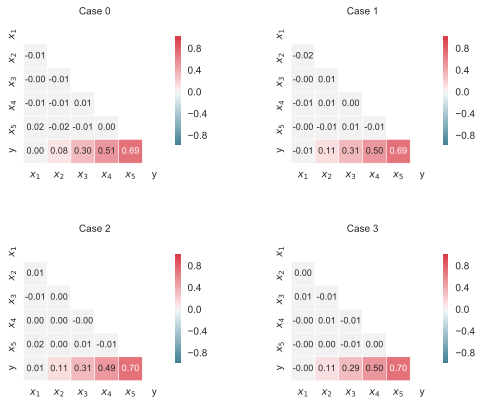

In [7]:
# plot correlation matrix
plt.style.use('seaborn-white')

fig, axs = plt.subplots(figsize=(8, 8), nrows = 2, ncols = 2)
fig.subplots_adjust(hspace=0, wspace=0.5)

axs_flatten = axs.flatten()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

for i in range(cases_no):
    
    corr = df_sets[i].corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, 
                annot = True, annot_kws={"size": 9}, fmt = '.2f',
                cmap=cmap, vmin = -1, vmax= 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = axs_flatten[i])
    axs_flatten[i].set_title('Case %d' % i, size = 10)
    
    axs_flatten[i].set_xticklabels(['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', 'y'])
    axs_flatten[i].set_yticklabels(['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', 'y'])

# fig.tight_layout()
plt.show()

plt.style.use('seaborn')

Drawing the distribution of dependent variables to visuallu control that there are that required skewness: 
* the *left* graph is the true distribution (we can draw it because we have exact distribution parameters),
* the *right* graph is the estimation of distribution with the kernel density estimation.

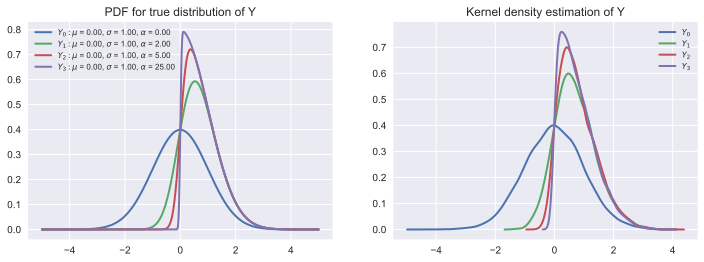

In [8]:
fig, axs = plt.subplots(figsize = (12, 4), ncols=2)

################################################################################
# draw ideal PDF of those DV's
################################################################################

plt.sca(axs[0])

x_range = np.linspace(-5, 5, total_sample_size)

for i in range(cases_no):
    # define a random variables with given parameters
    rv = norm_dist_params['y%d' % i]
    plt.plot(x_range, rv.pdf(x_range), lw = 2,
             label = r'$Y_%d: \mu$ = %1.2f, $\sigma$ = %1.2f, $\alpha$ = %1.2f' % 
             (i, rv.kwds['loc'], rv.kwds['scale'], rv.kwds['a']))

plt.title('PDF for true distribution of Y')
plt.legend(fontsize = 8)

################################################################################
# draw kernel distribuion estimation of the samples
################################################################################

plt.sca(axs[1])

for i in range(cases_no):
    kde = sm.nonparametric.KDEUnivariate(y[i])
    # kde.fit(kernel = 'epa', fft = False)
    kde.fit() # gaussian kernel with fft
    plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % i)

plt.title('Kernel density estimation of Y')
plt.legend(fontsize = 8)

plt.show()

Now, there are four sets of samples, one set per each required combination of DV and IVs in the variables y and x. Let's do some simulation with it.

## Probing Data for Knowledge (Linear Regression of Samples)

**The task:**

>Your simulations should do the following:
>1.	Create a linear regression model with one DV and 5 IVs (such that x1 correlates 10% with DV, x2 – 30%, etc.)
>2.	Generate 1000 (or more, if you wish) samples each of size 15, 30, 50, 100 for normal and skewed DVs
>3.	For each sample, run a linear regression and record R2, F-value, and p-values of each IV 
>4.	Analyze the results. Does non-normality have an impact on Type I and Type II error rates?



We understand the task is that we need to run the simulation for 1-4 for each set of DV and IVs (we have four of them, let's call them cases). Variability among runs of the experiment is defined by randomness of samples and their size.

Creating linear regression models for the full set of observations for each case, the models are stored in the *models* list. The values from these models can probably considered as the most accurate estimations, let's say, the true values.

In [9]:
import statsmodels.api as sm

models = []
fits   = []

for i in range(cases_no):
    models.append(sm.OLS(y[i], sm.add_constant(x[i])))
    fits.append(models[i].fit())

Listing the results for each case

In [10]:
for i in range(cases_no):
    print('******************************************************************************')
    print('* Case #%d                                                                    *' % i)
    print('******************************************************************************')
    print(fits[i].summary())
    print('')
    print('')

******************************************************************************
* Case #0                                                                    *
******************************************************************************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 1.018e+04
Date:                Fri, 22 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:21:55   Log-Likelihood:                -5161.4
No. Observations:               10000   AIC:                         1.033e+04
Df Residuals:                    9994   BIC:                         1.038e+04
Df Model:                           5                                         
Covariance Type:            nonrobust               

Creating major structures to work with those small but numerous samples (1000 per each case).

In [11]:
# number of iterations
iter_no = 1000

# sizes of samples
sample_sizes = (15, 30, 50, 100)

# samples in the following structure 
# {'case id': 
#     {'15':  <list of small samples>,
#      '30':  <list of small samples>,
#      '50':  <list of small samples>,
#      '100': <list of small samples>}}

samples = {}

# models for samples
samples_fits = {}

Just checking the logic of randomly selecting those small samples is correct.

In [13]:
# control

print('The first five observations')
print(y[0][:5])
print(x[0][:5,:])

print('')
indexes = [1, 2]
print('Choosing the observations %s' % indexes)
print(np.take(y[0], indexes))
print(np.take(x[0], indexes, axis = 0))

The first five observations
[-0.67849473  0.30549946 -0.59738106  0.11041805 -1.19717853]
[[-1.98057197 -0.16556335  0.10466595  0.43141548 -0.58162782]
 [-1.05498565 -0.03323694  1.15713368  0.29312238 -0.17470965]
 [ 0.58702841 -1.00675795 -1.58570505  0.48088585 -0.50307949]
 [ 0.14966891  1.53618953 -1.67174011 -0.53853997  0.70020088]
 [-1.02416233  0.56368623 -0.69458817 -2.90201279  1.49222993]]

Choosing the observations [1, 2]
[ 0.30549946 -0.59738106]
[[-1.05498565 -0.03323694  1.15713368  0.29312238 -0.17470965]
 [ 0.58702841 -1.00675795 -1.58570505  0.48088585 -0.50307949]]


In [14]:
np.random.seed(42)

for case in range(cases_no):
    samples[case] = {}
    for sample_size in sample_sizes:
        samples[case][sample_size] = []
        for j in range(iter_no):
            # randomly generating indexes for those observations we'll take for the current sample
            indexes = np.random.randint(0, total_sample_size - 1, sample_size)
            ys = np.take(y[case], indexes)
            xs = np.take(x[case], indexes, axis = 0)
            samples[case][sample_size].append([ys, xs])

Checking what a small sample looks like. It should be a list of two arrays: Y - the first one (1D), X - the second one (2D).

In [15]:
print('Y')
print()
print(samples[0][15][0][0])
print()
print('X1 - X5')
print()
print(samples[0][15][0][1])

Y

[ 1.20932447 -0.14963594  0.63452132  2.18117524 -1.57313602  0.96688342
 -0.81934159 -0.44032568 -0.10760344 -0.09138967  0.50697635  2.00640864
  0.05293947 -0.32759273 -0.19629362]

X1 - X5

[[-8.79856738e-01  2.39605237e-03  7.40041687e-02  2.52739527e+00
   2.99861215e-01]
 [ 6.17589237e-02  2.17363694e-01  2.03635680e+00  1.29622378e+00
  -1.26623307e+00]
 [ 3.43724678e-01 -1.50651066e+00 -1.10649645e+00  9.73282229e-01
   4.13644089e-01]
 [-3.39485047e-01 -1.02642944e+00 -3.76652324e-01  2.44146631e+00
   1.41808256e+00]
 [ 1.55501274e+00  1.43026490e+00 -2.27379493e-01 -1.29924178e+00
  -6.19362116e-01]
 [ 1.30257631e+00  3.30564556e-01 -3.07492483e-01  1.70223433e+00
   2.31198973e-01]
 [-2.04626543e+00 -2.38303908e+00  1.30733264e+00  8.45829420e-02
  -1.31068346e+00]
 [-8.97697112e-01  2.48468860e-02 -5.10405963e-01 -1.17836968e+00
   5.37718490e-01]
 [-1.34509862e+00  1.22128781e-01  1.52682711e+00 -7.01503156e-01
  -4.63088417e-01]
 [ 3.69261444e-01 -7.19310037e-01  5.1

Running the linear regression for those small samples. The results are gettings into the *samples_fits* variable. It has the same structure as *samples*.

In [16]:
for case in range(cases_no):
    samples_fits[case] = {}
    for sample_size in sample_sizes:
        samples_fits[case][sample_size] = []
        for sample in samples[case][sample_size]:
            ys = sample[0]
            xs = sample[1]
            m = sm.OLS(ys, sm.add_constant(xs)).fit()
            samples_fits[case][sample_size].append(m)

# Analysis

Let's build the distribution of each linear regression models' statistics we are interested in. Capturing those statistics into *stats*.

In [17]:
stats = {}

# stats in the following structure 
# {<case id>: 
#     {<sample size>: 
#         {'rsquared': list,
#          'fvalue':   list,
#          'pvalues':  list}}}

for case in range(cases_no):
    stats[case] = {}
    for sample_size in sample_sizes:
        stats[case][sample_size] = {}
        stats[case][sample_size]['rsquared'] = [sample_model.rsquared for sample_model in samples_fits[case][sample_size]]
        stats[case][sample_size]['fvalue']   = [sample_model.fvalue   for sample_model in samples_fits[case][sample_size]]
        stats[case][sample_size]['pvalues']  = [sample_model.pvalues  for sample_model in samples_fits[case][sample_size]]

## Distribution of R^2 (per each case and sample size)

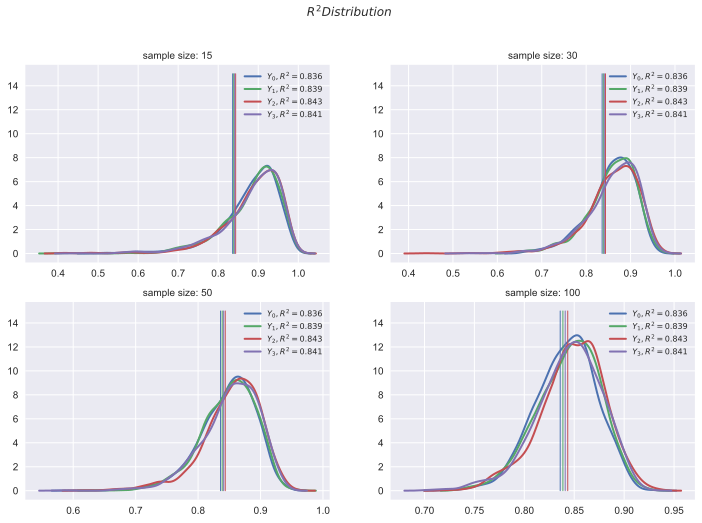

In [18]:
fig, axs = plt.subplots(figsize = (12, 8), nrows = 2, ncols=2)

axs_flatten = axs.flatten()

################################################################################
# draw ideal PDF of those DV's
################################################################################

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]
    plt.sca(axs_flatten[i])
    for case in range(cases_no):
        kde = sm.nonparametric.KDEUnivariate(stats[case][sample_size]['rsquared'])
        # kde.fit(kernel = 'epa', fft = False)
        kde.fit() # gaussian kernel with fft
        population_rsquared = fits[case].rsquared
        p = plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d, R^2 = %.3f$' % (case, population_rsquared))
        plt.plot([population_rsquared, population_rsquared], [0, 15], 'k-', lw=1, color = p[0].get_color())
        plt.legend(fontsize = 8)
        plt.title('sample size: %d' % sample_size, size = 10)
        # drawing true R^2

plt.suptitle('$R^2 Distribution$')        
        
plt.show()

## Distribution of F

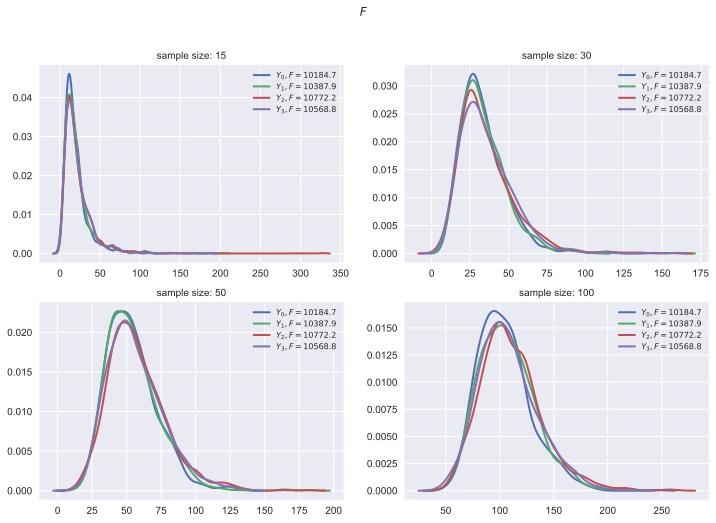

In [19]:
fig, axs = plt.subplots(figsize = (12, 8), nrows = 2, ncols=2)

axs_flatten = axs.flatten()

################################################################################
# draw ideal PDF of those DV's
################################################################################

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]
    plt.sca(axs_flatten[i])
    for case in range(cases_no):
        kde = sm.nonparametric.KDEUnivariate(stats[case][sample_size]['fvalue'])
        # kde.fit(kernel = 'epa', fft = False)
        kde.fit() # gaussian kernel with fft
        population_fvalue = fits[case].fvalue
        p = plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d, F = %.1f$' % (case, population_fvalue))
        # plt.plot([population_fvalue, population_fvalue], [0, 1], 'k-', lw=1, color = p[0].get_color())
        plt.legend(fontsize = 8)
        plt.title('sample size: %d' % sample_size, size = 10)

plt.suptitle('$F$')        
        
plt.show()

## Distribution of p-values

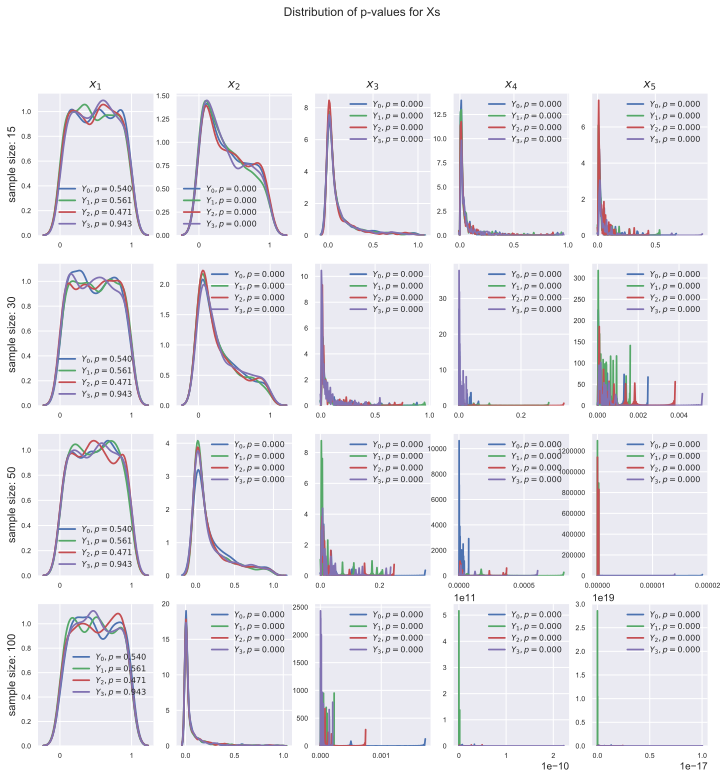

In [33]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 4, ncols=5)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axs_flatten = axs.flatten()

################################################################################
# draw ideal PDF of those DV's
################################################################################

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]    
    for j in range(5):
        plt.sca(axs[i][j])
        for case in range(cases_no):
            # getting p-values for the case, this sample size, this variable
            p = [pvalues[j+1] for pvalues in stats[case][sample_size]['pvalues']]
            
            #kde = sm.nonparametric.KDEUnivariate(p)
            #kde.fit() # gaussian kernel with fft
            #plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % case)
            
            population_pvalue = fits[case].pvalues[j+1]
            p = sns.distplot(p, hist = False, label='$Y_%d, p = %.3f$' % (case, population_pvalue))
            
            plt.legend(fontsize = 8)
            
            for tick in p.xaxis.get_major_ticks():
                tick.label.set_fontsize(7) 

            for tick in p.yaxis.get_major_ticks():
                tick.label.set_fontsize(7) 
                
for ax, j in zip(axs[0,:], range(5)):
    ax.set_title('$x_%d$' % (j + 1), size = 12)

for ax, sample_size in zip(axs[:,0], sample_sizes):
    ax.set_ylabel('sample size: %d' % sample_size, rotation=90)
                
#for ax in axs_flatten:
#    ax.label_outer()                
                
plt.suptitle('Distribution of p-values for X''s')
        
plt.show()

## Type I Error

What is Type I error for the case? We believe we consider the hypothesis about the true value of X.

# References

General

1. http://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html
2. https://en.wikipedia.org/wiki/Multicollinearity
3. https://en.wikipedia.org/wiki/Type_I_and_type_II_errors

The Cholesky transformation

1. https://www.quantumforest.com/2011/10/simulating-data-following-a-given-covariance-structure/
2. http://code.activestate.com/recipes/576512-generating-correlated-random-numbers/
3. https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution
4. https://blogs.sas.com/content/iml/2012/02/08/use-the-cholesky-transformation-to-correlate-and-uncorrelate-variables.html
5. https://math.stackexchange.com/questions/163470/generating-correlated-random-numbers-why-does-cholesky-decomposition-work